In [2]:
%matplotlib inline

from __future__ import division
import csv
import matplotlib.pyplot as plt
import numpy as np
import random
import time
from scipy import signal
from scipy import optimize
import pylab
import csv
from basic_definitions import *
from math import floor
import time      
from IPython.core.debugger import Tracer
import matlab.engine
from tqdm import tqdm
import scipy
from collections import Counter, defaultdict
from itertools import count




In [3]:
def digitize_wind(x,J_max,uniform=False):
    if uniform:
        x_sorted = np.array(sorted(x))
        bin_edge = np.linspace(0,len(x),num=J_max, endpoint=False, dtype=int)
        bins = x_sorted[bin_edge]
    else:
        bins = np.linspace(min(x),max(x),J_max)
    
    bins_states = np.append(bins,max(x))
    
    bin_means = []
    for i in range(J_max):
        bin_means.append((bins_states[i]+bins_states[i+1])/2)

    return np.digitize(x,bins)-1, np.array(bin_means)

In [4]:
def gather_wind_data(data_set="Filton_wind_record.csv",col=5):
    """
    Gathers wind data and makes a speed 
    """
    
    Speed = get_wind_data('Filton_wind_record.csv',col=5) # Filton_wind_record col=9   WindData col = 4 
    spd_all = []
    for i in Speed:
        try:
            spd_all.append(float(i)*0.514444)

        except ValueError:
            print i + " is not a float"

    # filter out negative wind speeds
    spd_all[:] = (value for value in spd_all if value >= 0)
           
        
    return spd_all


def make_Forecast(wind,order=2,digital_pass=0.1):
    """Low pass filter to generate wind forecast"""
    # Low Pass
    b, a = scipy.signal.butter(order,digital_pass, 'low') #4, 100, 'low'
    return scipy.signal.filtfilt(b, a,wind )

        
# Forecast = make_Forecast(spd_all)
    



In [5]:
def tmatrix(lst,J_max):
    """from http://stackoverflow.com/questions/28013878/calculate-transition-matrix-of-letters?lq=1
    defaultdict that'll produce a unique index for each unique character
    encountered in lst
    """

    # add thing to normalise
    a_state_chain = []# will contain each change of state twice
    for i in range(J_max):
        chain =  np.zeros(2*J_max)+int(i)
        chain = chain.tolist()
        for j in range(J_max):
            chain[j*2+1] = j

        a_state_chain.extend(chain)

    a_state_chain.append(0)

    lst = lst.tolist()
    lst.extend(a_state_chain) #don't use last J_max * J_max + 1 states
    lst = np.array(lst)
    
    
    
    indices = defaultdict(count().next)
    b = np.zeros([J_max,J_max])
    
    Ct = Counter(zip(lst, lst[1:])) # zip together consecutive elements of the list

    for (x, y), c in iter(sorted(Ct.iteritems())): # make sorted iteration to generate sorted trasition matrix
        #print (x,y), c
        b[indices[x]][indices[y]] = float(c)
       
    res = dict((v,k) for k,v in indices.iteritems())
    
    b = np.array(b)
    b = b-2 # remove the bit added for normalisations

    ##Normalise 
    for i in range(J_max):
        if float(b.sum(axis=1)[i]) > 0:
            b[i] = b[i]/float(b.sum(axis=1)[i])
        else:
            #  only zeros
            b[i] = b[i]
    
    # throw error if nan value
    if np.isnan(np.sum(b)):
        print b
        raise ValueError("NaN in T_mat")
       
        
    return b#, indices    
    #return output, indices


In [8]:
# tests for make_T_mat
# wind_test = np.random.randint(21,size=1000)
# T_mat, day_forecast, day_true,  Err_to_state, state_errors, Err, forecast = make_T_mat(wind_test,J_max=21,filter_order=2,filter_level=0.1,offset=25)

# print day_forecast
# print day_true

# plt.plot(day_forecast)
# plt.plot(day_true)
# plt.show()

In [9]:
def simple_scheduler(cost,min_pump_ops=0):
    """Takes a cost schedule and pumps at the minimum cost,
    pumps as many times as specified by the min_pump_ops"""
    
    cost_sort = sorted(cost.tolist())[0:min_pump_ops]
    print cost_sort
    sched =[]
    for i in cost:
        if i in cost_sort:
            sched.append(1)
            cost_sort.remove(i)
        else:
            sched.append(0)
            
    return np.array(sched)

In [10]:
def compute_stoch_cost2(T,Cost_true,state_true,schedule_DP,P_matrix,J_max,change_in_H,d_fact,H_rec,tank,pump_perf):   
    """
    Computes the operating cost given the actual wind realisations,
    a schedule to follow, the pump conditions and the probability
    matrix.
    
    Computes the stochastic operating cost given
    a certain schedule and the way the wind behaves.
    """
    #DP stuff
    Tot_cost_DP = schedule_DP[1+state_true[0],0]*Cost[state_true[0],0]
    Tot_cost_DP += schedule_DP[1+state_true[1],1]*Cost[state_true[1],1]
    sched_stoch_used = [schedule_DP[1+state_true[0],0], schedule_DP[1+state_true[1],1]]
    for i in range(2,T):        
        Cost_sim = Cost[:,i:i+T]
        Demand=np.roll(change_in_H*d_fact,-i)
        #print Demand
        Calc_Cost, schedule_DP, H_init, h_final, final_val,  H_rec = \
            call_val(H_rec[state_true[i]][1], t_init=0, j_init=state_true[i], T=T,Demand=Demand,\
            Energy=Cost_sim, J_max=J_max,P_matrix = P_matrix,tank=tank, pump_perf=pump_perf)
        #print schedule_DP[1,1+J_seq[i]]
        Tot_cost_DP += schedule_DP[1+state_true[i],1]*Cost_true[i]
        
        if ~np.isnan(schedule_DP[1+state_true[i],1]):
            sched_stoch_used.append(int(schedule_DP[1+state_true[i],1]))
        else:
            sched_stoch_used.append(0)
        
    # normalise schedule cost:
    sched_stoch_used = np.array(sched_stoch_used)
    #print sum(sched_stoch_used)    

        
    
    return Tot_cost_DP, sched_stoch_used

In [76]:
def make_T_mat(wind,J_max=21,filter_order=2,filter_level=0.1,offset=0):
    """
    Makes all the wind stats needed. Does not include the time from 
    end to offset in probability matrix generation.
    """
    
    b, a = scipy.signal.butter(filter_order,filter_level,'low') #4, 100, 'low'
    forecast = scipy.signal.filtfilt(b,a,wind)
    forecast = [i if i >= 0 else 0 for i in forecast]


    day_forecast = forecast[-offset:]
    day_true = wind[-offset:]

    errors = np.array(wind[:len(wind)-offset])-np.array(forecast[:len(wind)-offset])
    states, state_errors =digitize_wind(errors,J_max)

    
    Err = np.array([state_errors[i] for i in states])
    #T_mat, Err_to_state =  tmatrix(Err,J_max)
    #T_mat =  tmatrix(states,J_max)
    
    #print set(states)
    
    T_mat = Make_P_matrix(states)
    
    Err_to_state = dict(zip(state_errors,range(J_max)))
    
    return T_mat, day_forecast, day_true,  Err_to_state, state_errors, Err

In [77]:
T_mat, day_forecast, day_true,  Err_to_state, state_errors, Err\
                                                    = make_T_mat(Pwr,J_max=21,offset=T)



c = plt.pcolor(T_mat)
plt.set_cmap('gray_r')
plt.colorbar()
plt.axis([0,len(T_mat),0,len(T_mat)])
ax=plt.gca()                            # get the axis
ax.set_ylim(ax.get_ylim()[::-1])
plt.show()

In [78]:
def Make_P_matrix(Input,J_max=None):
    """
    From http://stats.stackexchange.com/questions/14360/estimating-markov-chain-probabilities   
    P(i,j) = n(i,j)/ sum(n(i,k) for k in m) where m is the total number of states
    """
    
    changes ={}
    if J_max is None:
        J_max =  max(Input)-min(Input)
        
    P = np.zeros((J_max+1,J_max+1))
    for i in range(J_max+1):
        changes[i] = []
        changes[i] = [Input[idx+1] for idx, val in enumerate(Input) if val == i and idx < len(Input)-1]
        
        if len(changes[i]) > 0:
            # if the state is used... else it the row is zero
            for j in range(J_max+1):
                P[i,j] = changes[i].count(j)/float(len(changes[i]))
        
    return P

In [85]:
## Wind
spd_all = gather_wind_data()

years = 1 # how many years are analysed initially 
spd = spd_all[0:365*24*years]       
Pwr = []
for i in spd:
    Pwr.append(Turb_power(i,Cutoff=25))
    
Pwr = np.array(Pwr)
# settings
J_max = 3
T = 6
d_fact = 0.7


## Network Settings
tank = Tank(Elev=20,Hmin=0,Hmax=2,Dia=10,levels = 100)
Pipe = pipe(L = 1000,D = 0.5,Method = "DW")
pump = Hyd_pump("ETAline-100-100-210-FSD.crv")
pump_power_con = 2500 #kW
DF = 1 # demand factor
Demand = [0.0379, 0.0398, 0.0426, 0.0473, 0.0379, 0.0369, 0.0426, 0.0530, 0.0568, 0.0757, 0.1325, 0.1609, 0.1704, 0.1515, 0.1136, 0.0947, 0.0757, 0.0710, 0.0682, 0.0663, 0.0710, 0.0663, 0.0757,  0.0776, 0.0757, 0.0748, 0.0899, 0.1041, 0.1231, 0.1136, 0.1041, 0.1325, 0.1515, 0.1562, 0.1704, 0.2083, 0.1609, 0.1704, 0.1231, 0.1136, 0.0757, 0.0663, 0.0473, 0.0426, 0.0379, 0.0379, 0.0379, 0.0360]
change_in_H = np.array(Demand)*60*60/4/tank.Area/10/0.89993*DF
change_in_H = list_length_adjustment(change_in_H,T)

Tariff = [5.7180, 5.7180, 5.7180, 5.7180, 5.7180, 5.7180, 5.7180, 5.7180, 5.7180, 5.7180, 5.7180, 17.1520, 17.1520, 17.1520, 17.1520, 17.1520, 17.1520, 17.1520, 17.1520, 9.6980, 9.6980, 9.6980, 9.6980, 9.6980, 9.6980, 9.6980, 9.6980, 9.6980, 9.6980, 9.6980, 9.6980, 9.6980, 9.6980, 17.1520, 17.1520, 17.1520, 17.1520, 17.1520, 17.1520, 17.1520, 9.6980, 9.6980, 9.6980, 9.6980, 5.7180, 5.7180, 5.7180, 5.7180]
Tariff = list_length_adjustment(Tariff,T)
export_price = 5.86


pump_perf = gen_flow_rate(tank.levels,tank,Pipe,pump,100)
Demand_DP = np.array(change_in_H)/2
Demand_DP = list_length_adjustment(Demand_DP,T)

WindSpeed is not a float


  0%|                                                    | 0/1 [00:00<?, ?it/s]

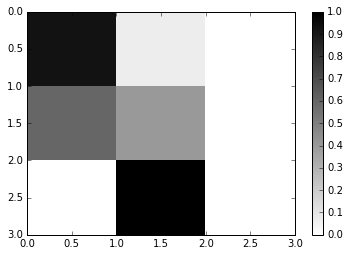

power_forecast_range  (3L, 6L)
[[ -629.87876941  -632.1247262   -633.84453914  -635.09099307
   -635.63114583  -635.63114583]
 [ 1146.89250298  1144.6465462   1142.92673325  1141.68027933
   1141.14012656  1141.14012656]
 [ 2035.27813918  2033.03218239  2031.31236945  2030.06591552
   2029.52576276  2029.52576276]]
[5.7523764204033068, 3.5064196360123123, 1.7866066915390375, 0.54015276856135741, 0, 0]


NameError: name 'wind_true' is not defined

In [86]:
T_mat_hist= []
for day in tqdm(range(1)):
    init = 365*24*years+T*day # set what day do analyse
   
    T_mat, day_forecast, day_true,  Err_to_state, state_errors, Err\
                                                    = make_T_mat(Pwr[0:init+T],J_max=J_max,offset=T)

    T_mat_hist.append(T_mat)
    
    if day in [0,200,400]:
        c = plt.pcolor(T_mat)
        plt.set_cmap('gray_r')
        plt.colorbar()
        plt.axis([0,len(T_mat),0,len(T_mat)])
        ax=plt.gca()                            # get the axis
        ax.set_ylim(ax.get_ylim()[::-1])
        plt.show()
    
    
    #A = np.array(Forecast[-(1+T*2):-1])
    #print "A", len(A)
    #print np.shape(A)
    
    #Err_day = Err[-T*2:]
    #print np.shape(Energy)
    #Err_day = discretise_wind(wind_true-A,factor=factor )  
    #Err_day = Err[init:init+48]
    #print Err_day
    #state_true =[]
    #print len(Err_day[0])
    #for i in Err_day:
        #print i
        #print Err_to_state
        #print Err_to_state(i)
        
        #state_true.append(Err_to_state[i])
        
    #print "state_true len", len(state_true)
    
    
    


    #print "len(set_of_Err_total) ", len(set_of_Err_total)
    power_forecast_range = np.array(day_forecast,ndmin=2)+np.array(state_errors,ndmin=2).T # set of possible wind ranges
    power_forecast_range[power_forecast_range < 0] = 0

    
    Cost = np.zeros_like( power_forecast_range)
    Cost_true= np.zeros_like(wind_true)
#     print "D", np.shape(D)
#     print np.shape(wind_true)
#     print np.shape(Tariff)
#     print T
    for i in range(0,T*2):
        Cost_true[i] = max((pump_power_con-Turb_power(wind_true[i],Cutoff=25))*Tariff[i],export_price) 
        for j in range(0,J_max):
            Pwr[j,i] = Turb_power(D[j,i],Cutoff=25)
            Cost[j,i] = max( (2500-Pwr[j,i])*Tariff[i],0)

            
    #print Cost_true
    #print np.shape(Cost)
    Cost_for_DP = Cost
    #print np.shape(Cost)
    
    Cost_for_det = Cost[int(np.floor(J_max/2.0)),:].tolist()
    
    
    #print "Av. det cost ", np.array(Cost_for_det).mean(),  
    #print "Av. true cost ", Cost_true.mean(),
    #print "Av. stoch cost ", Cost.mean(),
    
    #print np.shape(Cost_for_det), np.shape(Cost_for_DP), np.shape(Cost_true), 
    
    # Deterministic    
    Calc_Cost_det, Schedule_det, H_init_det, h_final_det, final_val_det = \
    call_val_det(H_init=1.0, t_init=0, j_init=state_true[0], T=T,Demand=change_in_H*d_fact,\
                                                           Energy=Cost_for_det, tank=tank, pump_perf=pump_perf)
    
    Tot_cost_det =np.dot(Cost_true[0:T],np.array(Schedule_det[1]))
    #
    #print "Schedule det ", Schedule_det[1]
    
    
    # Perfect
    Calc_Cost_perf, Schedule_perf, H_init_perf, h_final_perf, final_val_perf = \
    call_val_det(H_init=1.0, t_init=0, j_init=state_true[0], T=T,Demand=change_in_H*d_fact,\
                                                           Energy=Cost_true, tank=tank, pump_perf=pump_perf)
    
    #print "Schedule_perf ",Schedule_perf[1]
    
    # Stoc
    #print "np.shape(Cost_for_DP[0:24])", np.shape(Cost_for_DP[0:24])
    Calc_Cost, Schedule, H_init, h_final, final_val, H_rec = call_val(H_init=1.0, t_init=0, j_init= state_true[0], T=T,Demand=change_in_H*d_fact,\
                                                               Energy=Cost_for_DP[:,0:T], J_max=J_max,P_matrix = T_mat,\
                                                               tank=tank, pump_perf=pump_perf)

    Tot_cost_DP, schedule_stoc_used = compute_stoch_cost2(T,Cost_true,state_true, Schedule,\
                                                           T_mat,J_max,\
                                                          change_in_H,d_fact,H_rec,tank, pump_perf)
    
    Tot_cost_DP_actual = sum(Cost_true[0:T]*schedule_stoc_used)
    Tot_cost_DP_cor = Tot_cost_DP_actual*7/sum(schedule_stoc_used)
    #print "schedule_stoc_used ", schedule_stoc_used
    #simple schedulers
#     sched_simple_perf = simple_scheduler(Cost_true[0:24],min_pump_ops=7)
#     sched_simple_det = simple_scheduler(np.array(Cost_for_det[0:24]),min_pump_ops=7)
#     cost_simple_perf = sum(Cost_true[0:24]*sched_simple_perf)
#     cost_simple_det  = sum(Cost_true[0:24]*sched_simple_det)
#     print cost_simple_perf, cost_simple_det
    
    #print "Stoch sched: ", Schedule
    
    tot_det.append(Tot_cost_det)
    tot_det_planned.append(final_val_det)
    tot_dp.append(Tot_cost_DP_actual)
    tot_dp_cor.append(Tot_cost_DP_cor)
    tot_perf.append(Calc_Cost_perf[0])
    
    
    #print Schedule_det,Schedule_perf

In [90]:
print type( power_forecast_range)

<type 'numpy.ndarray'>


In [ ]:
import pandas as pd
df = pd.DataFrame([range(len(tot_perf)), tot_det,    tot_det_planned,     tot_dp,      tot_dp_cor,            tot_perf]).T
df.columns = ['Day' , 'Deterministic', 'Expected', 'Stochastic', 'Stochastic corrected', 'Perfect']
df['Difference'] = df['Deterministic']-df['Stochastic']
df['Difference cor'] = df['Deterministic']-df['Stochastic corrected']
#df.to_csv('changing_T_results_larege_1000_with_J21_cor.csv') # SAVING FILE!!
#df.rename(columns={0:'Deterministic', 1:'Expected', 2:'Stochastic', 3:'Stochastic corrected', 4:'Perfect'},inplace=True)
df

In [63]:
# Times J_max = 5
# 1:05:30 for 1000 = 3930s 0.16s per rep 
# for J = 41 -> 37s per rep

#     op_cost = sum(cost_sort[0:min_pump_ops])
    
#    return cost_sort#op_cost

cost = np.array([0,3,6,0,0.8,8,2,1,7,1])
simple_scheduler(cost,5)

[0.0, 0.0, 0.8, 1.0, 1.0]


array([1, 0, 0, 1, 1, 0, 0, 1, 0, 1])

In [82]:
Tot_cost_DP_actual

42397.405868617687

In [69]:
print schedule_DP[1+state_true[i],1]

NameError: name 'schedule_DP' is not defined

In [70]:
print np.array(Schedule_det[1])
print np.array(Schedule_perf[1])
print sum(Cost_true[0:24]*np.array(Schedule_perf[1]))
print np.dot(Cost_true[0:24],np.array(Schedule_det[1]))

[0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 1 0 0 1 1 1 1]
[1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 1 1 1]
0.0
0.0


In [78]:
np.isnan(float(NaN))

NameError: name 'NaN' is not defined

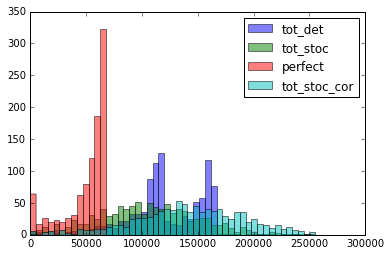

In [91]:
bins = np.linspace(0, max( max(tot_det), max(tot_dp), max(tot_det_planned)  ), 50)
#bins = np.linspace(0,500, 50)
plt.hist(tot_det, bins, alpha=0.5, label='tot_det')
plt.hist(tot_dp, bins, alpha=0.5, label='tot_stoc')
plt.hist(tot_perf, bins, alpha=0.5, label='perfect')
plt.hist(tot_dp_cor, bins, alpha=0.5, label='tot_stoc_cor')
plt.legend(loc='best')
plt.show()

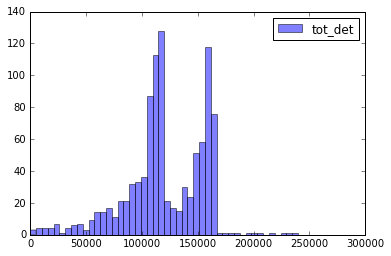

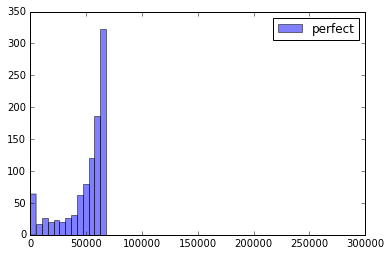

In [100]:
plt.hist(tot_det, bins, alpha=0.5, label='tot_det')
plt.legend(loc='best')
plt.show()

plt.hist(tot_perf, bins, alpha=0.5, label='perfect')
plt.legend(loc='best')
plt.show()

plt.hist(tot_dp_cor, bins, alpha=0.5, label='tot_stoc_cor')
plt.legend(loc='best')
plt.show()

In [25]:
names = {0:'A'}

df

Deterministic   Expected    Stochastic  Stochastic corrected  Perfect
0   10705.809348  100065.04      0.000000              0.000000      0.0
1   12652.467225  100065.04  22927.881325          20061.896159      0.0
2   14295.000000  100065.04      0.000000              0.000000      0.0
3   13807.405869  100065.04  28102.405869          28102.405869      0.0
4   14295.000000  100065.04      0.000000              0.000000      0.0
5   14295.000000  100065.04  28590.000000          25016.250000      0.0
6   12652.467225  100065.04  26992.450854          31491.192663      0.0
7   13111.541303  100065.04      0.000000              0.000000      0.0
8   13111.541303  100065.04      0.000000              0.000000      0.0
9   14295.000000  100065.04  28590.000000          28590.000000      0.0

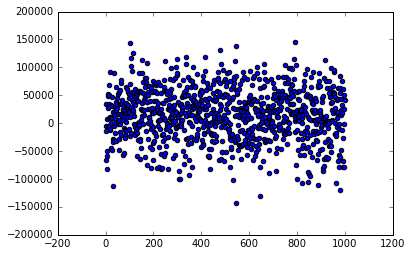

In [93]:
plt.scatter(df['Day'],df['Difference'])

In [98]:
print(df["Difference"].mean())
print(df["Deterministic"].mean())

15162.8056335
119868.925591


In [27]:
help(df.dropna)

Help on method dropna in module pandas.core.frame:

dropna(self, axis=0, how='any', thresh=None, subset=None, inplace=False) method of pandas.core.frame.DataFrame instance
    Return object with labels on given axis omitted where alternately any
    or all of the data are missing
    
    Parameters
    ----------
    axis : {0 or 'index', 1 or 'columns'}, or tuple/list thereof
        Pass tuple or list to drop on multiple axes
    how : {'any', 'all'}
        * any : if any NA values are present, drop that label
        * all : if all values are NA, drop that label
    thresh : int, default None
        int value : require that many non-NA values
    subset : array-like
        Labels along other axis to consider, e.g. if you are dropping rows
        these would be a list of columns to include
    inplace : boolean, default False
        If True, do operation inplace and return None.
    
    Returns
    -------
    dropped : DataFrame

